# Project Description and Goals

Project Description: Utilizing NLP I will attempt to make a classification predictive model that will be able to tell the primary programming language used by a github repository from the open source Microsoft page.

Project Goal: The ultimate goal of this project will be a predictive machine learning model that can predict programming language more accurately than the baseline, which in this case, will be the mode or most frequently occuring langauge.

## Pipeline Process

- Acquire: Collect data by web scraping names, languages, and readme contents off of Microsoft's open source github page

- Prepare: Take the readme content of each repo, and normalize the data by removing all accented and special characters, making all letters lowercase, tokenizing and lemmatizing each individual word, and finally removing all standard English stopwords

- Explore: Divide the data by language and see if there are any reoccuring trends or key phrases that would indicate language

- Modeling/Evaluation: Establish baseline and create classification models that will attempt to accurately predict the repo's language

- Deliver: Prepare a report and presentation to go over analysis and findings

###### environment setup

In [32]:
from requests import get
from bs4 import BeautifulSoup
import pandas as pd
import acquire

import itertools

import re
import unicodedata
import nltk

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

import acquire
import prepare

from pprint import pprint

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score

import os
import torch

# Acquisition

The data for this project was gathered by web scraping Microsoft's open source git hub page.

If you would like to see step by step on how that was accomplished, please check the wrangle jupyter notebook in this repository for step by step instructions.

The data was then cached into a csv file and I had written a function to call the data. The functions can be found in acquire.py file.

In [3]:
from acquire import acquire_microsoft

In [4]:
df = acquire_microsoft()

In [5]:
df.head()

,repo,language,readme_contents,is_TypeScript
0,microsoft/roosterjs-react,TypeScript,\n# Contributing\n\nThis project welcomes cont...,True
1,microsoft/vscode-azure-iot-toolkit,HTML,# Azure IoT Hub\n\n[![Join the chat at https:/...,False
2,microsoft/vscode-azuretools,TypeScript,# VSCode Azure SDK for Node.js\n\n[![Build Sta...,True
3,microsoft/knack,Python,Knack\n=====\n\n.. image:: https://img.shields...,False
4,microsoft/browsecloud,TypeScript,**BrowseCloud - Public Demo**\n\n[Try out Brow...,True


In [6]:
df.shape

(261, 4)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 261 entries, 0 to 269
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             261 non-null    object
 1   language         261 non-null    object
 2   readme_contents  261 non-null    object
 3   is_TypeScript    261 non-null    bool  
dtypes: bool(1), object(3)
memory usage: 8.4+ KB


The dataframe produced by this function has 4 features for each observation
   
   - repo: The name of the github repository
   
   - language: the primary programming langauge utilized in the repository
   
   - readme_contents: the unformated content of the repository's readme file
   
   - is_TypeScript: a boolean value indicating whether the langauge of the repository is TypeScript, which is by far the most common language
        - Further researcch indicated that TypeScript is Microsoft's personal programming language, so this would make sense

# Preparation

The data for this project was prepared by removing any null values, as repos with no content were not usable for this project

The data in the readme_contents feature was then prepared for NLP exploration and modeling
    
    - All characters made lowercase
    - All accented characters converted to normal characters
    - All special characters removed
    - All individual words tokenized and lemmatized
    - All standard English stopwords removed

Every method mentioned above was accomplished utilizing functions that can be found in the prepare.py file

In [8]:
from prepare import prepare_microsoft

In [9]:
df.readme_contents = df.readme_contents.apply(prepare_microsoft)

In [10]:
df.head()

,repo,language,readme_contents,is_TypeScript
0,microsoft/roosterjs-react,TypeScript,contributing project welcome contribution sugg...,True
1,microsoft/vscode-azure-iot-toolkit,HTML,azure iot hub join chat httpsgitterimmicrosoft...,False
2,microsoft/vscode-azuretools,TypeScript,vscode azure sdk nodejs build statushttpsdevaz...,True
3,microsoft/knack,Python,knack image httpsimgshieldsiopypivknacksvg tar...,False
4,microsoft/browsecloud,TypeScript,browsecloud public demo try browsecloud demons...,True


In [11]:
df.readme_contents[0]

'contributing project welcome contribution suggestion contribution require agree contributor license agreement cla declaring right actually grant u right use contribution detail visit httpsclamicrosoftcom submit pull request clabot automatically determine whether need provide cla decorate pr appropriately eg label comment simply follow instruction provided bot need across repos using cla project ha adopted microsoft open source code conducthttpsopensourcemicrosoftcomcodeofconduct information see code conduct faqhttpsopensourcemicrosoftcomcodeofconductfaq contact opencodemicrosoftcommailtoopencodemicrosoftcom additional question comment'

# Exploration

### Q1: How many languages are there?

In [12]:
# first see how many values are in our target variable
df.language.value_counts()

TypeScript          126
C#                   32
JavaScript           18
C++                  16
Python               16
Jupyter Notebook      8
PowerShell            7
HTML                  7
C                     5
CSS                   4
Java                  3
Shell                 3
Go                    2
Ruby                  2
JSON                  2
Rust                  1
F#                    1
SCSS                  1
Dafny                 1
Objective-C           1
Kotlin                1
CMake                 1
Swift                 1
Liquid                1
Q#                    1
Name: language, dtype: int64

In [13]:
len(df.language.value_counts())

25

### Takeaways 

- Among the first thing that I noticed was that there were many different languages in the data that I had gathered

- Some were decently frequent

- TypeScript accounted for nearly half of the repositories 

- Most languages only showed up once or twice which made me question their value to the project

### Q2: What are the most common words among Typescript repos vs non Typescript repos

In [14]:
# seperate all TypeScript repos into their own dataframe
typescript = df[df['is_TypeScript'] == True]

In [15]:
# seperate all non-TypeScript repos into their own dataframe
non_typescript = df[df['is_TypeScript'] == False]

In [16]:
# make a list of all the words in typescript repos
typescript_words = (' '.join(df[df.is_TypeScript == True].readme_contents)).split()

# make a list of all the words in non-typescript repos
other_words = (' '.join(df[df.is_TypeScript == False].readme_contents)).split()

# make a list of all the words in all the repos
all_words = (' '.join(df.readme_contents)).split()

In [17]:
# count the frequency of each unique word in typescript repos
typescript_freq = pd.Series(typescript_words).value_counts()

# count the frequency of each unique word in non-typescript repos
other_freq = pd.Series(other_words).value_counts()

# count the frequency of each unique word in all repos
all_freq = pd.Series(all_words).value_counts()

In [21]:
typescript_freq.head()

'          675
code       491
run        436
project    402
use        351
dtype: int64

In [19]:
other_freq.head()

'          922
code       614
build      519
use        448
project    437
dtype: int64

In [20]:
all_freq.head()

'          1597
code       1105
run         856
project     839
build       823
dtype: int64

#### Takeaways

- the apostrophe character is the most reoccuring feature all around

- the words 'code', 'use', and 'project' show up in the top 5 of both typescript and non typescript repos

### Q3: Are there any words that uniquely identify Typescript vs non Typescript

In [24]:
# put word counts into seperate df

word_counts = (pd.concat([all_freq, typescript_freq, other_freq], axis=1, sort=True)
                .set_axis(['all', 'Typescript', 'other'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts_df = word_counts.sort_values(by='all', ascending=False)

In [25]:
word_counts_df.head()

,all,Typescript,other
',1597,675,922
code,1105,491,614
run,856,436,420
project,839,402,437
build,823,304,519


In [26]:
pd.concat([word_counts[word_counts.Typescript == 0].sort_values(by='other').tail(6),
           word_counts[word_counts.other == 0].sort_values(by='Typescript').tail(6)])

,all,Typescript,other
lia,60,0,60
vcpkg,64,0,64
codepush,78,0,78
fhir,90,0,90
appcenter,101,0,101
quantum,206,0,206
expo,29,29,0
serial,34,34,0
reactnative,34,34,0
packager,35,35,0


#### Takeaways 

- there are quite a few words such as 'quantum' and 'appcenter' which appear in non typescript but not in typescript

- there are words that appear exclusively in typescript that don't appear in non typescript, but they are not as frequent

### Q4: Proportion of Typescript vs other for the 20 most common words

Text(0.5, 1.0, 'Proportion of Typescript vs other for the 20 most common words')

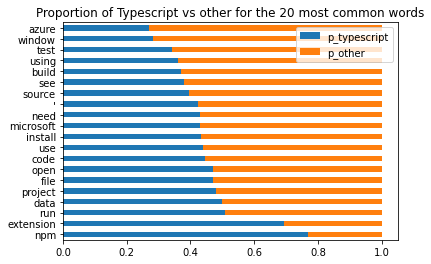

In [27]:
# figure out the percentage of typescript vs other
(word_counts
 .assign(p_typescript=word_counts.Typescript / word_counts['all'],
         p_other=word_counts.other / word_counts['all'])
 .sort_values(by='all')
 [['p_typescript', 'p_other']]
 .tail(20)
 .sort_values('p_other')
 .plot.barh(stacked=True))

plt.title('Proportion of Typescript vs other for the 20 most common words')

### Word Clouds

- Word clous were made to help visualize the prominance or words or phrases in the data

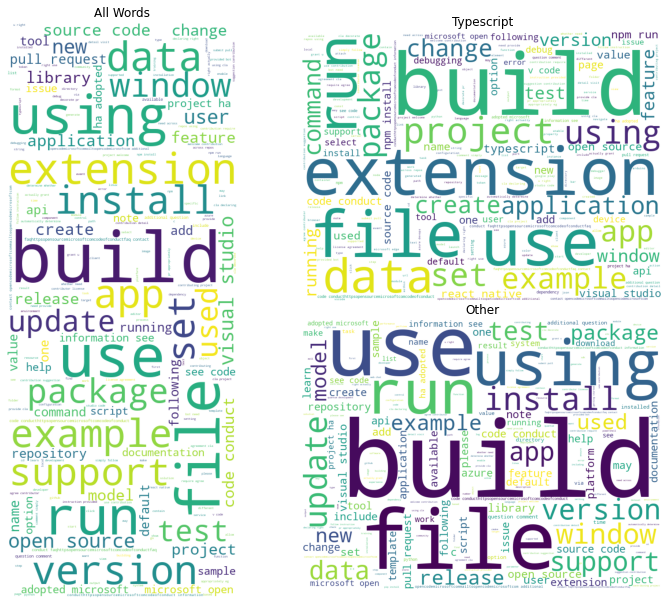

In [28]:
# make word clouds
all_cloud = WordCloud(background_color='white', height=1000, width=400).generate(' '.join(all_words))
typescript_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(typescript_words))
other_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(other_words))

# specify plot details
plt.figure(figsize=(10, 8))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5])]

axs[0].imshow(all_cloud)
axs[1].imshow(typescript_cloud)
axs[2].imshow(other_cloud)

axs[0].set_title('All Words')
axs[1].set_title('Typescript')
axs[2].set_title('Other')

for ax in axs: ax.axis('off')

#### Bigrams

In [29]:
# make typescript bigrams
top_20_typescript_bigrams = (pd.Series(nltk.ngrams(typescript_words, 2))
                      .value_counts()
                      .head(20))

# make non typescript bigrams
top_20_other_bigrams = (pd.Series(nltk.ngrams(other_words, 2))
                      .value_counts()
                      .head(20))

# make all bigrams
top_20_all_bigrams = (pd.Series(nltk.ngrams(all_words, 2))
                      .value_counts()
                      .head(20))

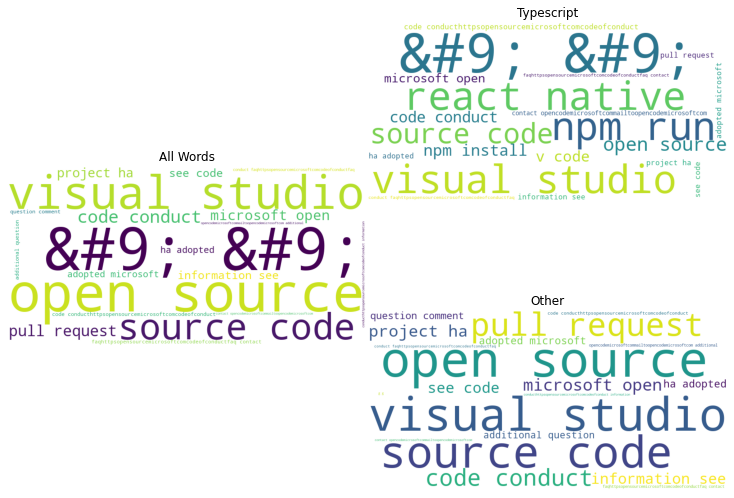

In [30]:
# make word clouds
data = {k[0] + ' ' + k[1]: v for k, v in top_20_all_bigrams.to_dict().items()}
all_cloud = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)

ts_data = {k[0] + ' ' + k[1]: v for k, v in top_20_typescript_bigrams.to_dict().items()}
typescript_cloud = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(ts_data)

other_data = {k[0] + ' ' + k[1]: v for k, v in top_20_other_bigrams.to_dict().items()}
other_cloud = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(other_data)

# specify plot details
plt.figure(figsize=(10, 8))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5])]

axs[0].imshow(all_cloud)
axs[1].imshow(typescript_cloud)
axs[2].imshow(other_cloud)

axs[0].set_title('All Words')
axs[1].set_title('Typescript')
axs[2].set_title('Other')

for ax in axs: ax.axis('off')

# Modeling

The data in this project was modeled in 2 different ways, both using classification machine learning models.

First modeling attempted to predict is_TypeScript, a boolean value indicating whether or not the repository's primary language was or was not TypeScript, Microsoft's own personal programming language.

Secondly, I then attempted to make models that would predict language, while only looking at the top 5 most prevalent languages.

In each instance I established a baseline, and then created Logistic Regression, Decision Tree, Random Forest, and K Nearest Neighbors models with default settings to see if they would perform better than the baseline.

### - is_TypeScript

In [33]:
# make TF-IDF object
tfidf = TfidfVectorizer()

# fit object to list of words
X = tfidf.fit_transform(df.readme_contents)

# make the y variable of the target variable
y = df.is_TypeScript

# seperate into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2, random_state=319)

# set up as dataframes
train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

train['baseline'] = False
# most actual values are false, so we will use that as baseline

In [34]:
train.head()

,actual,baseline
257,True,False
65,True,False
207,False,False
136,True,False
99,True,False


In [71]:
print(' Baseline Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.baseline)))

AttributeError: 'DataFrame' object has no attribute 'baseline'

#### Takeaways

- The baseline of False has an accuracy of 51.92%, the goal is to make a model with a higher accuracy

### Model: Logistic Regression

Of all the models used on this data, the logistic regression with default settings performed the best on unseen data, so it was used for evaluation

In [37]:
# create object and fit to train
lm = LogisticRegression(random_state=319).fit(X_train, y_train)

# make predictions
train['log_predicted'] = lm.predict(X_train)
test['log_predicted'] = lm.predict(X_test)

print('Train Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.log_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.log_predicted, train.actual))
print('---')
print(classification_report(train.actual, train.log_predicted))

Train Accuracy: 97.12%
---
Confusion Matrix
actual         False  True 
log_predicted              
False            105      3
True               3     97
---
              precision    recall  f1-score   support

       False       0.97      0.97      0.97       108
        True       0.97      0.97      0.97       100

    accuracy                           0.97       208
   macro avg       0.97      0.97      0.97       208
weighted avg       0.97      0.97      0.97       208



In [38]:
print('Test Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.log_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.log_predicted, test.actual))
print('---')
print(classification_report(test.actual, test.log_predicted))

Test Accuracy: 69.81%
---
Confusion Matrix
actual         False  True 
log_predicted              
False             24     13
True               3     13
---
              precision    recall  f1-score   support

       False       0.65      0.89      0.75        27
        True       0.81      0.50      0.62        26

    accuracy                           0.70        53
   macro avg       0.73      0.69      0.68        53
weighted avg       0.73      0.70      0.69        53



#### Takeaways

- There is an extremely high accuracy on train vs and much less impressive accuracy on test
    - sign that the model is overfit?
    

- Even though the model does not perform as well on unseen test data than it did on the sample data, it still performs better than the baseline with nearly 18% improvement

## - Language

In [39]:
df.head()

,repo,language,readme_contents,is_TypeScript
0,microsoft/roosterjs-react,TypeScript,contributing project welcome contribution sugg...,True
1,microsoft/vscode-azure-iot-toolkit,HTML,azure iot hub join chat httpsgitterimmicrosoft...,False
2,microsoft/vscode-azuretools,TypeScript,vscode azure sdk nodejs build statushttpsdevaz...,True
3,microsoft/knack,Python,knack image httpsimgshieldsiopypivknacksvg tar...,False
4,microsoft/browsecloud,TypeScript,browsecloud public demo try browsecloud demons...,True


In [40]:
# find only the most common languages
top_5 = df.language.value_counts().head()

top_5

TypeScript    126
C#             32
JavaScript     18
C++            16
Python         16
Name: language, dtype: int64

In [42]:
top_5_languages = ['TypeScript', 'C#', 'JavaScript', 'C++', 'Python']

# make into a seperate dataframe
top_5_df = df[df['language'].isin(top_5_languages)]

In [46]:
from prepare import split

train, validate, test = split(top_5_df, 'language')
# split data into train, validate, and test, stratifying on langauge

train['baseline'] = 'TypeScript'
# 'TypeScript' will be used as baseline because it is the most common

In [47]:
train.head()

,repo,language,readme_contents,is_TypeScript,baseline
33,microsoft/cookie.gulp,JavaScript,contributing project welcome contribution sugg...,False,TypeScript
39,microsoft/electionguard-ballot-box,TypeScript,microsoft defending democracy program election...,True,TypeScript
47,microsoft/onnxruntime,C++,p aligncenterimg width50 srcdocsimagesonnxrunt...,False,TypeScript
238,microsoft/fhir-server,C#,fhir server azure net core implementation fhir...,False,TypeScript
130,microsoft/openpaimarketplace,JavaScript,p aligncenter img srcdocsimagesmarketplacesvg ...,False,TypeScript


In [49]:
# make list of all unique languages
languages = train.language.value_counts().index.tolist()

# Train Accuracy
train_accuracy = (train.language == train.baseline).mean()

train_accuracy

0.6120689655172413

#### Takeaways

- The baseline of False has an accuracy of 61.21%, the goal is to make a model with a higher accuracy

### Model: Decision Tree

Of all the models I used on this data, the decision tree with default settings performed the best and was the ony model to beat the baseline on out of sample data

In [53]:
# Setup our X variables
X_train = train.readme_contents
X_validate = validate.readme_contents
X_test = test.readme_contents

# Setup our y variables
y_train = train.language
y_validate = validate.language
y_test = test.language

# Create TF-IDF object
tfidf = TfidfVectorizer()

# Fit on the training data
tfidf.fit(X_train)

# Use the object
X_train_vectorized = tfidf.transform(X_train)
X_validate_vectorized = tfidf.transform(X_validate)
X_test_vectorized = tfidf.transform(X_test)

# make into pd dataframes
train = pd.DataFrame(dict(actual=y_train))
validate = pd.DataFrame(dict(actual=y_validate))
test = pd.DataFrame(dict(actual=y_test))

In [54]:
# make decision tree object
dt = DecisionTreeClassifier(random_state = 319)

# fit object to train data
dt.fit(X_train_vectorized, y_train)

# make predictions, add to dataframe
train['dt_predicted'] = dt.predict(X_train_vectorized)
validate['dt_predicted'] = dt.predict(X_validate_vectorized)
test['dt_predicted'] = dt.predict(X_test_vectorized)

train.head()

,actual,dt_predicted
33,JavaScript,JavaScript
39,TypeScript,TypeScript
47,C++,C++
238,C#,C#
130,JavaScript,JavaScript


In [55]:
# Train Accuracy
(train.actual == train.dt_predicted).mean()

0.9827586206896551

In [63]:
for language in languages:
    language_repos = train[train.actual == language]
    accuracy = (language_repos.actual == language_repos.dt_predicted).mean()
    print(f"Predicting {language} on Train has {(round(accuracy, 4) * 100)}% accuracy")

Predicting TypeScript on Train has 98.59% accuracy
Predicting C# on Train has 94.12% accuracy
Predicting JavaScript on Train has 100.0% accuracy
Predicting C++ on Train has 100.0% accuracy
Predicting Python on Train has 100.0% accuracy


In [64]:
print(classification_report(train.actual, train.dt_predicted))

              precision    recall  f1-score   support

          C#       1.00      0.94      0.97        17
         C++       1.00      1.00      1.00         9
  JavaScript       0.83      1.00      0.91        10
      Python       1.00      1.00      1.00         9
  TypeScript       1.00      0.99      0.99        71

    accuracy                           0.98       116
   macro avg       0.97      0.99      0.97       116
weighted avg       0.99      0.98      0.98       116



In [65]:
# Out of sample accuracy
(validate.actual == validate.dt_predicted).mean()

0.64

In [66]:
for language in languages:
    language_repos = validate[validate.actual == language]
    accuracy = (language_repos.actual == language_repos.dt_predicted).mean()
    print(f"Predicting {language} on Validate has {(round(accuracy, 4) * 100)}% accuracy")

Predicting TypeScript on Validate has 80.0% accuracy
Predicting C# on Validate has 75.0% accuracy
Predicting JavaScript on Validate has 0.0% accuracy
Predicting C++ on Validate has 25.0% accuracy
Predicting Python on Validate has 25.0% accuracy


In [67]:
print(classification_report(validate.actual, validate.dt_predicted))

              precision    recall  f1-score   support

          C#       0.86      0.75      0.80         8
         C++       0.25      0.25      0.25         4
  JavaScript       0.00      0.00      0.00         4
      Python       0.11      0.25      0.15         4
  TypeScript       0.83      0.80      0.81        30

    accuracy                           0.64        50
   macro avg       0.41      0.41      0.40        50
weighted avg       0.66      0.64      0.65        50



#### Takeaways

- This model performed very well on train, but did not do as well on validate
    - Likely a sign that the model is overfit
    
    
- This model still outperformed on unseen test data, however

### Evaluate

In [68]:
# test accuracy
(test.actual == test.dt_predicted).mean()

0.5714285714285714

In [69]:
for language in languages:
    language_repos = test[test.actual == language]
    accuracy = (language_repos.actual == language_repos.dt_predicted).mean()
    print(f"Predicting {language} on Test has {(round(accuracy, 4) * 100)}% accuracy")

Predicting TypeScript on Test has 72.0% accuracy
Predicting C# on Test has 42.86% accuracy
Predicting JavaScript on Test has 0.0% accuracy
Predicting C++ on Test has 33.33% accuracy
Predicting Python on Test has 66.67% accuracy


In [70]:
print(classification_report(test.actual, test.dt_predicted))

              precision    recall  f1-score   support

          C#       0.75      0.43      0.55         7
         C++       0.17      0.33      0.22         3
  JavaScript       0.00      0.00      0.00         4
      Python       0.40      0.67      0.50         3
  TypeScript       0.72      0.72      0.72        25

    accuracy                           0.57        42
   macro avg       0.41      0.43      0.40        42
weighted avg       0.59      0.57      0.57        42



#### Takeaways

- Ultimately this final model was unable to perform better than the baseline on unseen test data

- Future iterations may require adjustments to the parameters, or perhaps just more data?

# Conclusion

While I was able to make a predictive model that could more accurately predict whether or not a repo's primary was TypeScript using it as a binary feature, I was ultimately unable to make a model that could also predict language when it is used as a discreet feature with multiple values that perfroms better than baseline.

If I had more time I would like to recreate this expirement using significantly more data.
    - More data from Microsoft's github.
    - Possibly data from githubs of other organizations as well.

Also I would like to make new models using different parameters to see if it would give a much more accurate outcome.